### Fetal Immune - Splitting and clustering for annotation

In this notebook we generate a coarse clustering of the batch corrected Fetal Immune Atlas to split into broad cell lineages on which we will do detailed re-annotation. 

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from time import time
from datetime import datetime
import seaborn as sns

### Load data

In [3]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.h5ad")

In [4]:
## Here I am adding the labels post-hoc
# These will be already saved in the anndata in future iterations
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv", index_col=0)
# new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.clustering.obs.csv", index_col=0)
adata.obs = new_obs

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
cl_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.clustering.obs.csv", index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
adata.obs = pd.concat([adata.obs, cl_obs.loc[adata.obs_names][["leiden_100", "leiden_050"]]],axis=1)

... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'method' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical


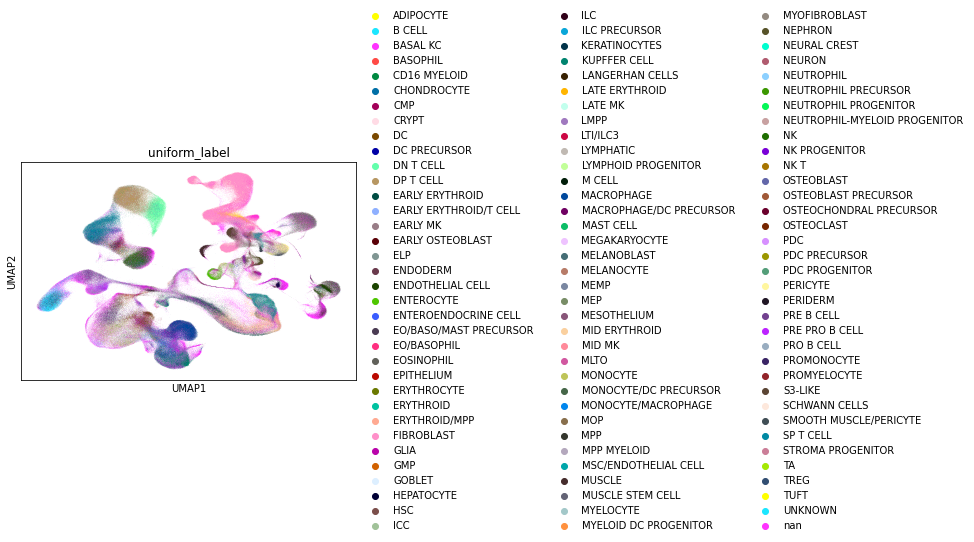

In [14]:
sc.pl.umap(adata, color="uniform_label")

### Clustering

In [204]:
start=datetime.now()
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_050', n_iterations=5)
lei_time = datetime.now()-start
print("Leiden runtime: ", str(lei_time))


Leiden runtime:  0:25:15.707417


In [ ]:
start=datetime.now()
sc.tl.leiden(adata, resolution=1, key_added='leiden_100', n_iterations=5)
lei_time = datetime.now()-start
print("Leiden runtime: ", str(lei_time))

In [15]:
adata.obs["leiden_050"]=adata.obs["leiden_050"].astype("category")
adata.obs["leiden_100"]=adata.obs["leiden_100"].astype("category")

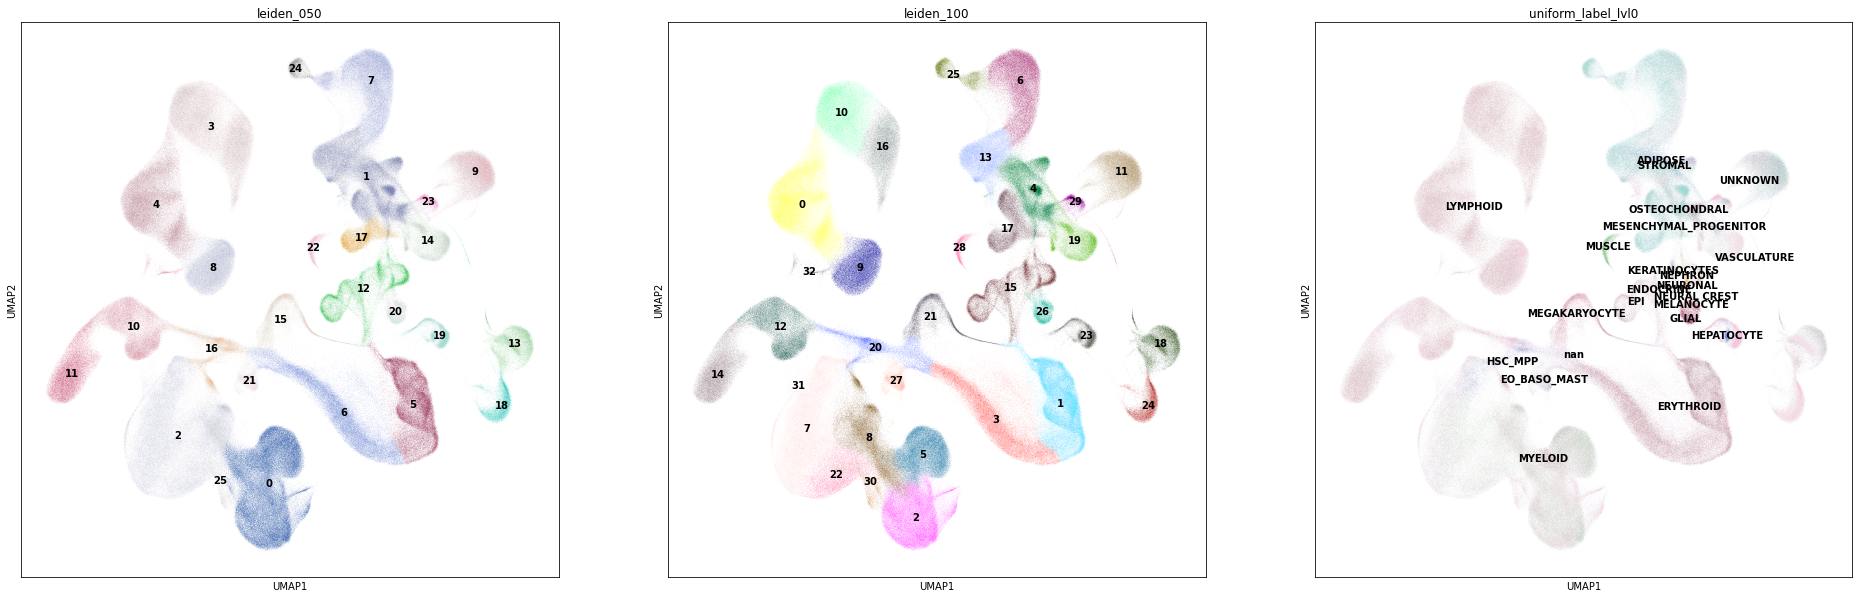

In [16]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=['leiden_050','leiden_100', 'uniform_label_lvl0'], legend_loc="on data")

### Add putative labels based on the most abundant cells in clusters

In [17]:
adata.obs['leiden_100'] = [str(x) for x in adata.obs['leiden_100']]

In [18]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_lvl0', 'leiden_100','index']] \
    .dropna() \
    .groupby(['leiden_100', 'uniform_label_lvl0']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_100'], index=['uniform_label_lvl0'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_100_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_100_pred_label'] = pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label'].values

In [19]:
## Add predicted uniform label based on most frequent cell type
cl_counts = adata.obs.reset_index()[["uniform_label_expanded_merged", 'leiden_100','index']] \
    .dropna() \
    .groupby(['leiden_100', "uniform_label_expanded_merged"]) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_100'], index=["uniform_label_expanded_merged"])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_100_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_100_pred_label_expanded'] = pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label'].values

... storing 'leiden_100' as categorical
... storing 'leiden_100_pred_label' as categorical
... storing 'leiden_100_pred_label_expanded' as categorical


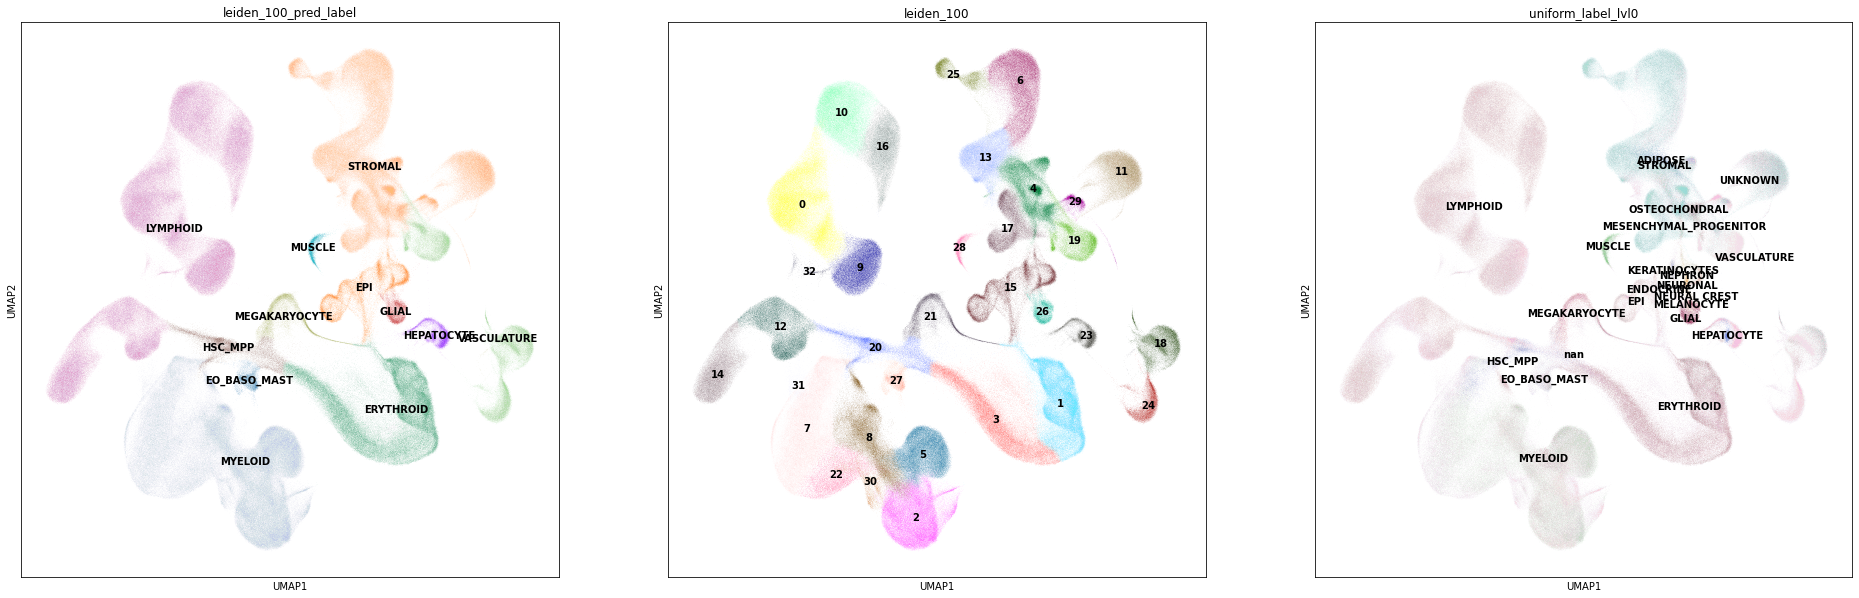

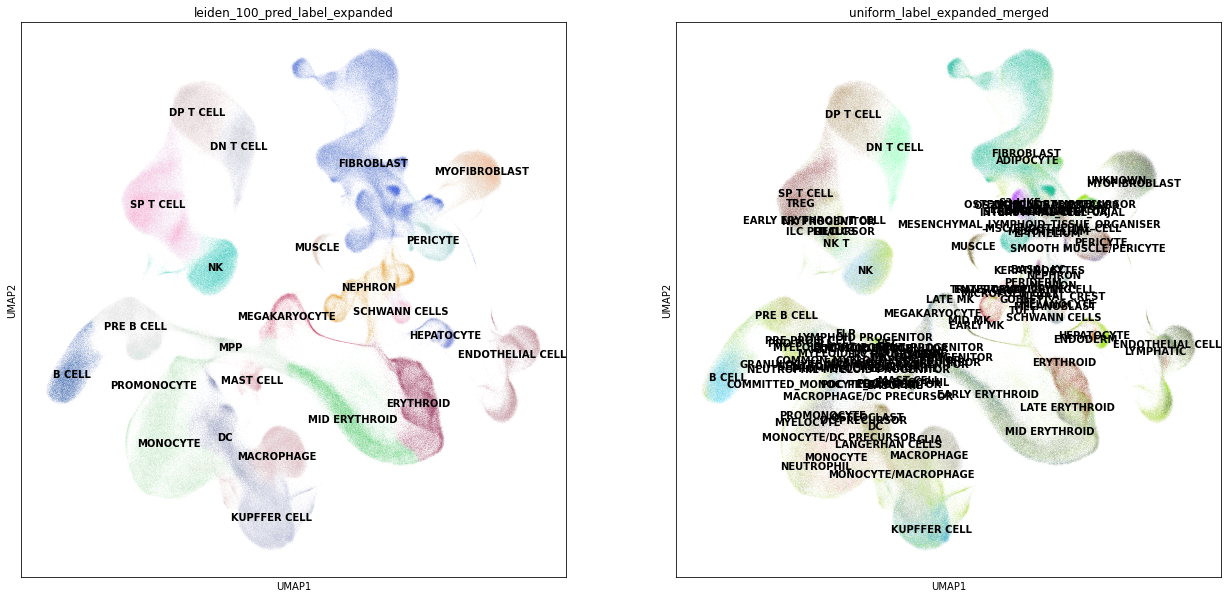

In [20]:
sc.pl.umap(adata, color=['leiden_100_pred_label','leiden_100', 'uniform_label_lvl0'], legend_loc="on data")
sc.pl.umap(adata, color=['leiden_100_pred_label_expanded',"uniform_label_expanded_merged"], legend_loc="on data")

In [21]:
## Define hierarchy for making data subsets
pfi_splitting_df = adata.obs[['leiden_100_pred_label', 'leiden_100_pred_label_expanded']].drop_duplicates()
hsc_immune_lvl0 = ["LYMPHOID", "MYELOID", "HSC_MPP", "MEGAKARYOCYTE", "ERYTHROID", "EO_BASO_MAST"]
pfi_splitting_df["split_1"] = ["HSC_IMMUNE" if x in hsc_immune_lvl0 else "STROMA" for x in pfi_splitting_df['leiden_100_pred_label']]
pfi_splitting_df["split_2"] = [
    "MEM_PROGENITORS" if x in ["HSC_MPP","MEGAKARYOCYTE", "ERYTHROID"]
    else "MYELOID" if x in ["MYELOID", "EO_BASO_MAST"]
    else "LYMPHOID" if x in ["LYMPHOID"]
    else "STROMA"
    for x in pfi_splitting_df['leiden_100_pred_label']
]
pfi_splitting_df["split_3"] = pfi_splitting_df["split_2"]
pfi_splitting_df["split_3"] = [
    "NKT" if pfi_splitting_df['leiden_100_pred_label_expanded'].loc[i] in ["DN T CELL", "SP T CELL", "DP T CELL", "NK"]
    else "B" if "B CELL" in pfi_splitting_df['leiden_100_pred_label_expanded'].loc[i]
    else pfi_splitting_df["split_3"].loc[i]
    for i in pfi_splitting_df.index
]

pfi_splitting_df.sort_values(["split_1", "split_2", 'split_3'])

,leiden_100_pred_label,leiden_100_pred_label_expanded,split_1,split_2,split_3
index,,,,,
FCAImmP7179363-AAACCTGGTGAGTGAC,LYMPHOID,PRE B CELL,HSC_IMMUNE,LYMPHOID,B
FCAImmP7179363-AAACGGGCAATAACGA,LYMPHOID,B CELL,HSC_IMMUNE,LYMPHOID,B
FCAImmP7179363-AAACGGGAGTTAGCGG,LYMPHOID,NK,HSC_IMMUNE,LYMPHOID,NKT
FCAImmP7179363-AACACGTTCGATAGAA,LYMPHOID,SP T CELL,HSC_IMMUNE,LYMPHOID,NKT
FCAImmP7179363-ATCATCTGTAGGAGTC,LYMPHOID,DN T CELL,HSC_IMMUNE,LYMPHOID,NKT
FCAImmP7179366-CATCAGAGTGCAGGTA,LYMPHOID,DP T CELL,HSC_IMMUNE,LYMPHOID,NKT
FCAImmP7179363-AAACCTGGTAGAGGAA,ERYTHROID,MID ERYTHROID,HSC_IMMUNE,MEM_PROGENITORS,MEM_PROGENITORS
FCAImmP7179363-AAACGGGAGTGAATTG,ERYTHROID,ERYTHROID,HSC_IMMUNE,MEM_PROGENITORS,MEM_PROGENITORS
FCAImmP7179363-AACACGTTCGCAAGCC,HSC_MPP,MPP,HSC_IMMUNE,MEM_PROGENITORS,MEM_PROGENITORS


In [22]:
adata.obs = adata.obs.merge(pfi_splitting_df, on=['leiden_100_pred_label_expanded', 'leiden_100_pred_label'], how='left', indicator=False)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


... storing 'split_1' as categorical
... storing 'split_2' as categorical
... storing 'split_3' as categorical


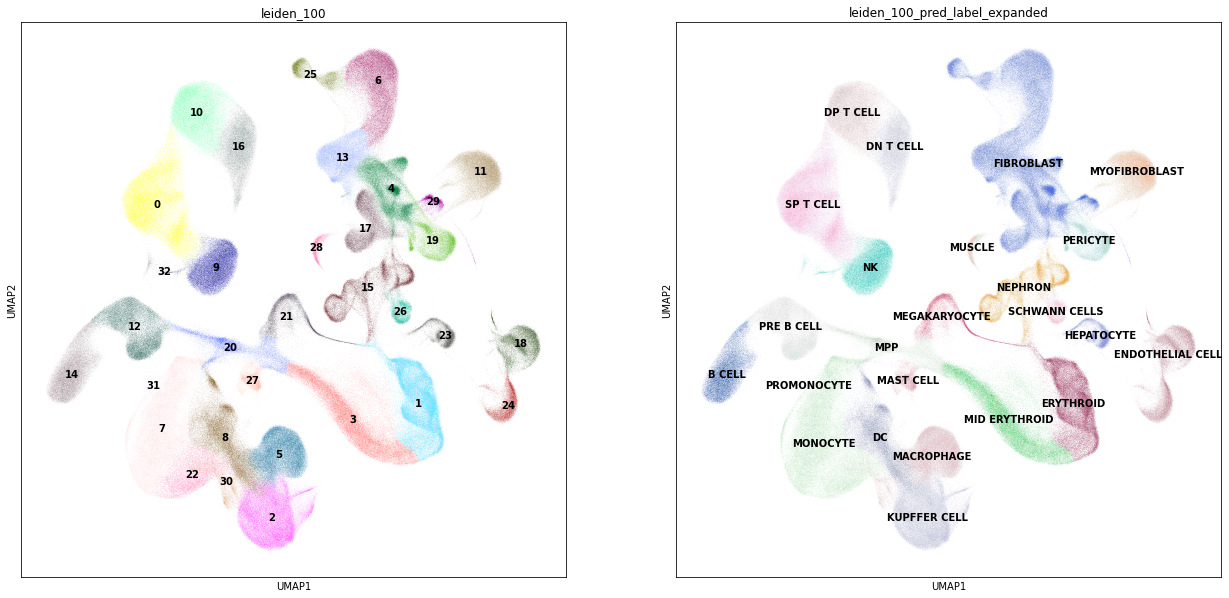

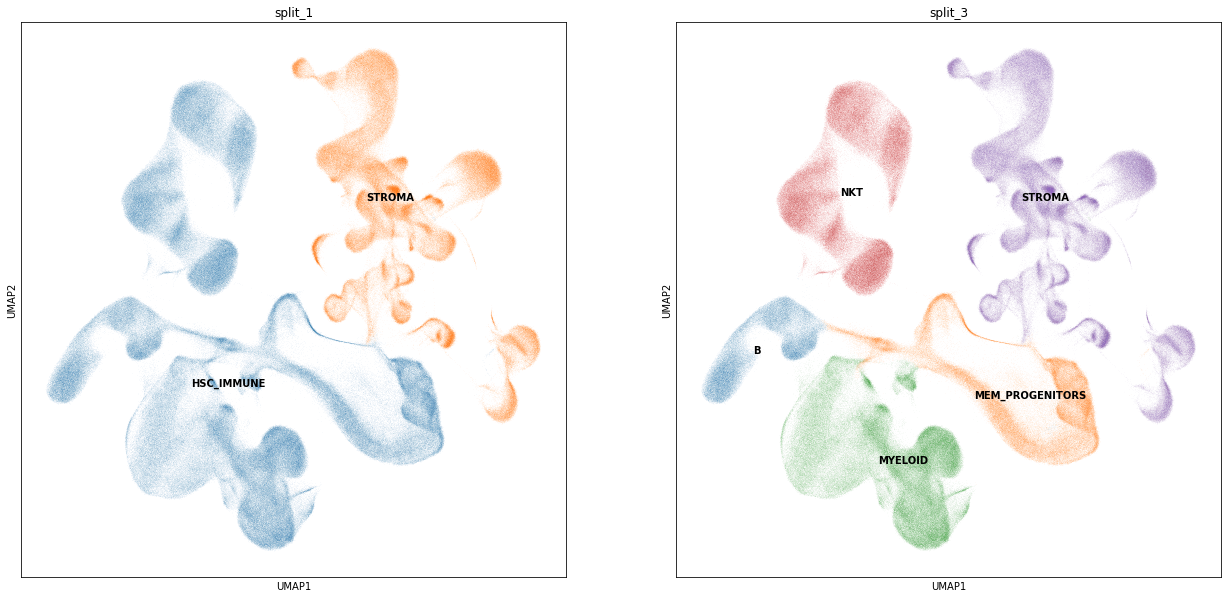

In [23]:
sc.pl.umap(adata, color=["leiden_100", 'leiden_100_pred_label_expanded'], legend_loc="on data")
sc.pl.umap(adata, color=["split_1", "split_3"], legend_loc="on data")

In [90]:
# adata.obs[adata.obs.split_3=="B"].value_counts("uniform_label")
split_df = adata.obs.reset_index()[["uniform_label_expanded_merged", 'split_3','index']] \
    .dropna() \
    .groupby(['split_3', "uniform_label_expanded_merged"]) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['split_3'], index=["uniform_label_expanded_merged"])

split_df =split_df[split_df.index!="nan"]

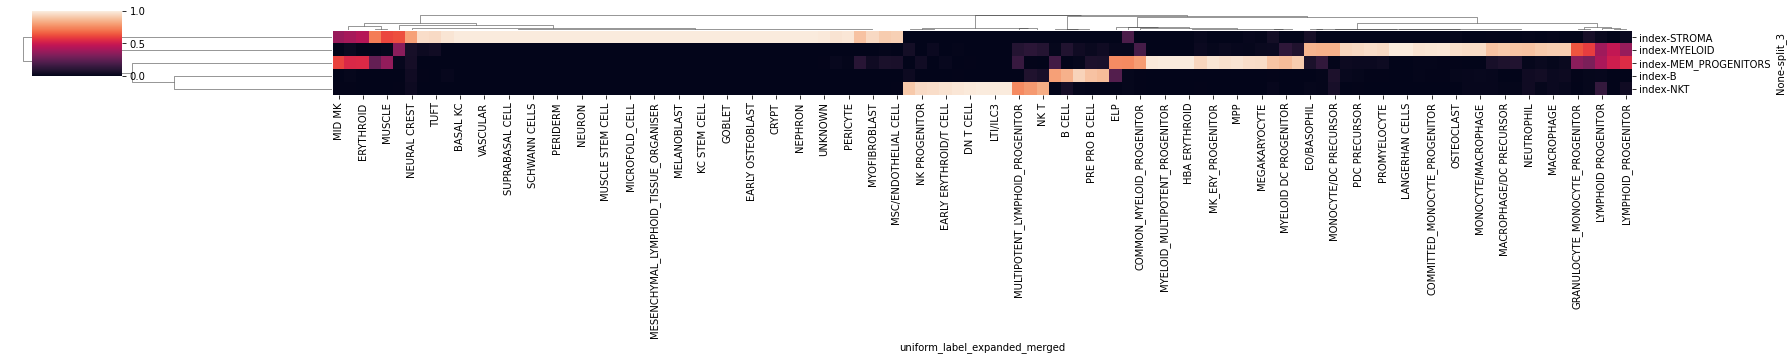

In [98]:
sns.clustermap((split_df.T/split_df.sum(1)), figsize=[25,5])

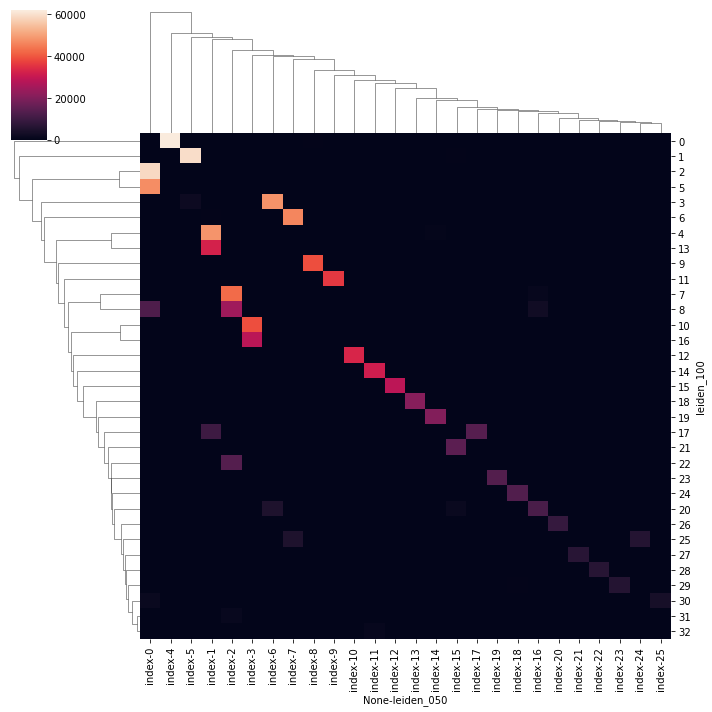

In [225]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.clustermap(cl_counts, 
#             norm=LogNorm()
           )

### Save clustering output

In [294]:
## Save raw data with reductions

## Save clustering results
adata.obs.to_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.clustering.obs.csv")

### Split datasets

Load normalized data pre-correction and feature selection

In [56]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

merged_raw.obs_names = obs_names

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
merged_raw.obs = adata.obs.copy()

Split based on splits

In [77]:
save_path = '/nfs/team205/ed6/data/Fetal_immune/'
suffix = 'PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112'
split_col = "split_3"

splits = adata.obs[split_col].unique()

In [ ]:
for s in splits:
    adata_name = save_path + "{}.{}.h5ad".format(suffix, s)
    sdata = merged_raw[adata.obs[split_col]==s]
    print("Saving {} anndata ({} cells, {} organs)".format(s, sdata.obs_names.shape[0], sdata.obs["organ"].unique().shape[0]))
    sdata.write_h5ad(adata_name)

Saving MYELOID anndata (217267 cells, 9 organs)
Saving MEM_PROGENITORS anndata (143461 cells, 9 organs)
Saving B anndata (64981 cells, 9 organs)
Saving NKT anndata (169995 cells, 9 organs)
Saving STROMA anndata (318091 cells, 9 organs)
